In [18]:
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import pandas as pd
import time
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [19]:

def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div

In [20]:
import yfinance as yf

In [21]:
fb=yf.Ticker('FB')

In [22]:
df =fb.history(start="2010-01-01",  end="2020-08-31")

In [23]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18,42.05,45.00,38.00,38.23,573576400,0,0
2012-05-21,36.53,36.66,33.00,34.03,168192700,0,0
2012-05-22,32.61,33.59,30.94,31.00,101786600,0,0
2012-05-23,31.37,32.50,31.36,32.00,73600000,0,0
2012-05-24,32.95,33.21,31.77,33.03,50237200,0,0
...,...,...,...,...,...,...,...
2020-08-24,271.07,277.25,268.77,271.39,23685600,0,0
2020-08-25,272.41,283.09,270.26,280.82,42127200,0,0
2020-08-26,284.00,304.67,284.00,303.91,69015200,0,0


In [24]:
parameters = [df['Close'].tolist(), df['Volume'].tolist()]

In [25]:

def get_state(parameters, t, window_size = 20):
    outside = []
    d = t - window_size + 1
    for parameter in parameters:
        block = (
            parameter[d : t + 1]
            if d >= 0
            else -d * [parameter[0]] + parameter[0 : t + 1]
        )
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        for i in range(1, window_size, 1):
            res.append(block[i] - block[0])
        outside.append(res)
    return np.array(outside).reshape((1, -1))

In [26]:

inventory_size = 1
mean_inventory = 0.5
capital = 2
concat_parameters = np.concatenate([get_state(parameters, 20), [[inventory_size, 
                                                                mean_inventory,
                                                                capital]]], axis = 1)

79

In [28]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights
    
    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')
        
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.rand(input_size, layer_size)
            * np.sqrt(1 / (input_size + layer_size)),
            np.random.rand(layer_size, output_size)
            * np.sqrt(1 / (layer_size + output_size)),
            np.zeros((1, layer_size)),
            np.zeros((1, output_size)),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-2]
        decision = np.dot(feed, self.weights[1]) + self.weights[-1]
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, timeseries, skip, initial_money, real_trend, minmax):
        self.model = model
        self.timeseries = timeseries
        self.skip = skip
        self.real_trend = real_trend
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        self.minmax = minmax
        self._initiate()

    def _initiate(self):
        # i assume first index is the close value
        self.trend = self.timeseries[0]
        self._mean = np.mean(self.trend)
        self._std = np.std(self.trend)
        self._inventory = []
        self._capital = self.initial_money
        self._queue = []
        self._scaled_capital = self.minmax.transform([[self._capital, 2]])[0, 0]

    def reset_capital(self, capital):
        if capital:
            self._capital = capital
        self._scaled_capital = self.minmax.transform([[self._capital, 2]])[0, 0]
        self._queue = []
        self._inventory = []

    def trade(self, data):
        """
        you need to make sure the data is [close, volume]
        """
        scaled_data = self.minmax.transform([data])[0]
        real_close = data[0]
        close = scaled_data[0]
        if len(self._queue) >= window_size:
            self._queue.pop(0)
        self._queue.append(scaled_data)
        if len(self._queue) < window_size:
            return {
                'status': 'data not enough to trade',
                'action': 'fail',
                'balance': self._capital,
                'timestamp': str(datetime.now()),
            }
        state = self.get_state(
            window_size - 1,
            self._inventory,
            self._scaled_capital,
            timeseries = np.array(self._queue).T.tolist(),
        )
        action, prob = self.act_softmax(state)
        print(prob)
        if action == 1 and self._scaled_capital >= close:
            self._inventory.append(close)
            self._scaled_capital -= close
            self._capital -= real_close
            return {
                'status': 'buy 1 unit, cost %f' % (real_close),
                'action': 'buy',
                'balance': self._capital,
                'timestamp': str(datetime.now()),
            }
        elif action == 2 and len(self._inventory):
            bought_price = self._inventory.pop(0)
            self._scaled_capital += close
            self._capital += real_close
            scaled_bought_price = self.minmax.inverse_transform(
                [[bought_price, 2]]
            )[0, 0]
            try:
                invest = (
                    (real_close - scaled_bought_price) / scaled_bought_price
                ) * 100
            except:
                invest = 0
            return {
                'status': 'sell 1 unit, price %f' % (real_close),
                'investment': invest,
                'gain': real_close - scaled_bought_price,
                'balance': self._capital,
                'action': 'sell',
                'timestamp': str(datetime.now()),
            }
        else:
            return {
                'status': 'do nothing',
                'action': 'nothing',
                'balance': self._capital,
                'timestamp': str(datetime.now()),
            }

    def change_data(self, timeseries, skip, initial_money, real_trend, minmax):
        self.timeseries = timeseries
        self.skip = skip
        self.initial_money = initial_money
        self.real_trend = real_trend
        self.minmax = minmax
        self._initiate()

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))

        return np.argmax(decision[0])

    def act_softmax(self, sequence):
        decision = self.model.predict(np.array(sequence))

        return np.argmax(decision[0]), softmax(decision)[0]

    def get_state(self, t, inventory, capital, timeseries):
        state = get_state(timeseries, t)
        len_inventory = len(inventory)
        if len_inventory:
            mean_inventory = np.mean(inventory)
        else:
            mean_inventory = 0
        z_inventory = (mean_inventory - self._mean) / self._std
        z_capital = (capital - self._mean) / self._std
        concat_parameters = np.concatenate(
            [state, [[len_inventory, z_inventory, z_capital]]], axis = 1
        )
        return concat_parameters

    def get_reward(self, weights):
        initial_money = self._scaled_capital
        starting_money = initial_money
        invests = []
        self.model.weights = weights
        inventory = []
        state = self.get_state(0, inventory, starting_money, self.timeseries)

        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= self.trend[t]

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]
                invest = ((self.trend[t] - bought_price) / bought_price) * 100
                invests.append(invest)

            state = self.get_state(
                t + 1, inventory, starting_money, self.timeseries
            )
        invests = np.mean(invests)
        if np.isnan(invests):
            invests = 0
        score = (starting_money - initial_money) / initial_money * 100
        return invests * 0.7 + score * 0.3

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self._scaled_capital
        starting_money = initial_money

        real_initial_money = self.initial_money
        real_starting_money = self.initial_money
        inventory = []
        real_inventory = []
        state = self.get_state(0, inventory, starting_money, self.timeseries)
        states_sell = []
        states_buy = []

        for t in range(0, len(self.trend) - 1, self.skip):
            action, prob = self.act_softmax(state)
            print(t, prob)

            if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - 1 - window_size):
                inventory.append(self.trend[t])
                real_inventory.append(self.real_trend[t])
                real_starting_money -= self.real_trend[t]
                starting_money -= self.trend[t]
                states_buy.append(t)
                print(
                    'day %d: buy 1 unit at price %f, total balance %f'
                    % (t, self.real_trend[t], real_starting_money)
                )

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                real_bought_price = real_inventory.pop(0)
                starting_money += self.trend[t]
                real_starting_money += self.real_trend[t]
                states_sell.append(t)
                try:
                    invest = (
                        (self.real_trend[t] - real_bought_price)
                        / real_bought_price
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.real_trend[t], invest, real_starting_money)
                )
            state = self.get_state(
                t + 1, inventory, starting_money, self.timeseries
            )

        invest = (
            (real_starting_money - real_initial_money) / real_initial_money
        ) * 100
        total_gains = real_starting_money - real_initial_money
        return states_buy, states_sell, total_gains, invest


In [29]:
stocks=['CPRT','AMD','GWR','MTDR', 'GOOG','TSLA','FSV', 'LB','FB','SINA', 'LYFT']

In [30]:
skip = 1
layer_size = 500
output_size = 3
window_size = 20

In [31]:
for no, stock in enumerate(stocks):
    print('training stock %s'%(stock))
    fb=yf.Ticker('FB')    
    df =yf.Ticker(stock).history(start="2010-01-01",  end="2020-08-31")

training stock CPRT
training stock AMD
training stock GWR
training stock MTDR
training stock GOOG
training stock TSLA
training stock FSV
training stock LB
training stock FB
training stock SINA
training stock LYFT


In [32]:
input_size = concat_parameters.shape[1]
input_size

79

In [35]:
model = Model(input_size = input_size, layer_size = layer_size, output_size = output_size)
agent = None

for no, stock in enumerate(stocks):
    print('training stock %s'%(stock))
    fb=yf.Ticker('FB')    
    df =yf.Ticker(stock).history(start="2016-01-01",  end="2020-08-31")
    
    real_trend = df['Close'].tolist()
    parameters = [df['Close'].tolist(), df['Volume'].tolist()]
    minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
    scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
    initial_money = np.max(parameters[0]) * 2
    
    if no == 0:
        agent = Agent(model = model,
                      timeseries = scaled_parameters,
                      skip = skip,
                      initial_money = initial_money,
                      real_trend = real_trend,
                      minmax = minmax)
    else:
        agent.change_data(timeseries = scaled_parameters,
                          skip = skip,
                          initial_money = initial_money,
                          real_trend = real_trend,
                          minmax = minmax)
    
    agent.fit(iterations = 100, checkpoint = 10)
    print()

training stock CPRT
iter 10. reward: 14.846497
iter 20. reward: 18.354806
iter 30. reward: 21.252275
iter 40. reward: 31.768293
iter 50. reward: 40.928623
iter 60. reward: 37.976643
iter 70. reward: 35.819130
iter 80. reward: 36.885473
iter 90. reward: 33.921545
iter 100. reward: 37.395681
time taken to train: 294.92205572128296 seconds

training stock AMD
iter 10. reward: 17.314249
iter 20. reward: 18.862641
iter 30. reward: 25.654004
iter 40. reward: 35.285459
iter 50. reward: 36.055304
iter 60. reward: 37.432109
iter 70. reward: 39.431538
iter 80. reward: 37.857249
iter 90. reward: 40.038821
iter 100. reward: 31.174576
time taken to train: 269.92313861846924 seconds

training stock GWR
iter 10. reward: -17.488113
iter 20. reward: 6.837102
iter 30. reward: 17.461144
iter 40. reward: 32.165351
iter 50. reward: 31.613472
iter 60. reward: 33.325971
iter 70. reward: 33.463068
iter 80. reward: 33.461764
iter 90. reward: 36.052707
iter 100. reward: 39.681859
time taken to train: 201.199792

In [48]:
df = yf.Ticker('GOOG').history(start="2018-01-01",  end="2020-08-31")
real_trend = df['Close'].tolist()
parameters = [df['Close'].tolist(), df['Volume'].tolist()]
minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
initial_money = np.max(parameters[0]) * 2

    
agent.change_data(timeseries = scaled_parameters,
                  skip = skip,
                  initial_money = initial_money,
                  real_trend = real_trend,
                  minmax = minmax)

states_buy, states_sell, total_gains, invest = agent.buy()

0 [0. 0. 1.]
1 [0. 0. 1.]
2 [0. 0. 1.]
3 [0. 0. 1.]
4 [0. 0. 1.]
5 [0. 0. 1.]
6 [8.80342838e-145 0.00000000e+000 1.00000000e+000]
7 [1. 0. 0.]
8 [0. 0. 1.]
9 [2.77834119e-80 0.00000000e+00 1.00000000e+00]
10 [0. 0. 1.]
11 [1. 0. 0.]
12 [1.00000000e+000 0.00000000e+000 1.85055218e-268]
13 [0. 0. 1.]
14 [1. 0. 0.]
15 [1. 0. 0.]
16 [1. 0. 0.]
17 [0. 0. 1.]
18 [1. 0. 0.]
19 [1. 0. 0.]
20 [1. 0. 0.]
21 [1. 0. 0.]
22 [0. 0. 1.]
23 [0. 0. 1.]
24 [0. 0. 1.]
25 [0. 1. 0.]
day 25: buy 1 unit at price 1048.580000, total balance 2256.180000
26 [0. 0. 1.]
day 26, sell 1 unit at price 1001.520000, investment -4.487974 %, total balance 3257.700000,
27 [0. 0. 1.]
28 [1. 0. 0.]
29 [1. 0. 0.]
30 [0. 1. 0.]
day 30: buy 1 unit at price 1069.700000, total balance 2188.000000
31 [0. 0. 1.]
day 31, sell 1 unit at price 1089.520000, investment 1.852856 %, total balance 3277.520000,
32 [0. 1. 0.]
day 32: buy 1 unit at price 1094.800000, total balance 2182.720000
33 [0. 1. 0.]
day 33: buy 1 unit at price 1102.4

422 [0. 1. 0.]
423 [0. 1. 0.]
424 [0. 1. 0.]
425 [1. 0. 0.]
426 [1. 0. 0.]
427 [1.36690316e-78 0.00000000e+00 1.00000000e+00]
day 427, sell 1 unit at price 1239.560000, investment 4.339189 %, total balance 1324.210000,
428 [0. 0. 1.]
day 428, sell 1 unit at price 1231.300000, investment 4.560122 %, total balance 2555.510000,
429 [0. 1. 0.]
day 429: buy 1 unit at price 1229.150000, total balance 1326.360000
430 [0. 1. 0.]
day 430: buy 1 unit at price 1232.410000, total balance 93.950000
431 [1. 0. 0.]
432 [1. 0. 0.]
433 [1. 0. 0.]
434 [1.00000000e+000 1.01890411e-191 0.00000000e+000]
435 [0. 1. 0.]
436 [1. 0. 0.]
437 [1. 0. 0.]
438 [1. 0. 0.]
439 [1. 0. 0.]
440 [3.05806044e-210 0.00000000e+000 1.00000000e+000]
day 440, sell 1 unit at price 1176.630000, investment 0.662167 %, total balance 1270.580000,
441 [0. 1. 0.]
day 441: buy 1 unit at price 1187.830000, total balance 82.750000
442 [1. 0. 0.]
443 [9.99465996e-01 5.34003653e-04 0.00000000e+00]
444 [1. 0. 0.]
445 [1.00000000e+000 4.488

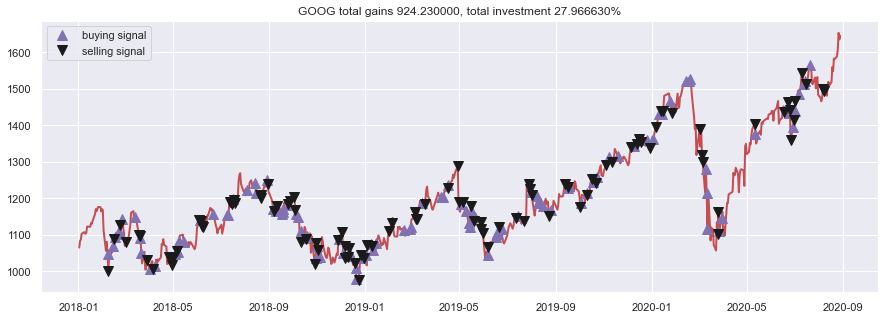

In [49]:

fig = plt.figure(figsize = (15, 5))
plt.plot(df['Close'], color='r', lw=2.)
plt.plot(df['Close'], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(df['Close'], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('GOOG total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [46]:
df = yf.Ticker('TWTR').history(start="2018-01-01",  end="2020-08-31")
real_trend = df['Close'].tolist()
parameters = [df['Close'].tolist(), df['Volume'].tolist()]
minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
initial_money = np.max(parameters[0]) * 2

agent.change_data(timeseries = scaled_parameters,
                  skip = skip,
                  initial_money = initial_money,
                  real_trend = real_trend,
                  minmax = minmax)

states_buy, states_sell, total_gains, invest = agent.buy()

0 [0. 0. 1.]
1 [0. 0. 1.]
2 [0. 0. 1.]
3 [0. 0. 1.]
4 [0. 0. 1.]
5 [0. 0. 1.]
6 [0. 0. 1.]
7 [0. 0. 1.]
8 [0. 0. 1.]
9 [0. 0. 1.]
10 [0. 0. 1.]
11 [0.00000000e+000 1.00000000e+000 1.72673866e-239]
day 11: buy 1 unit at price 24.040000, total balance 69.480000
12 [0. 1. 0.]
day 12: buy 1 unit at price 23.660000, total balance 45.820000
13 [0. 0. 1.]
day 13, sell 1 unit at price 23.320000, investment -2.995008 %, total balance 69.140000,
14 [0. 0. 1.]
day 14, sell 1 unit at price 22.750000, investment -3.846154 %, total balance 91.890000,
15 [1. 0. 0.]
16 [0. 0. 1.]
17 [0. 1. 0.]
day 17: buy 1 unit at price 24.270000, total balance 67.620000
18 [0. 0. 1.]
day 18, sell 1 unit at price 25.180000, investment 3.749485 %, total balance 92.800000,
19 [0. 0. 1.]
20 [0.00e+000 1.00e+000 7.56e-322]
day 20: buy 1 unit at price 25.810000, total balance 66.990000
21 [0. 0. 1.]
day 21, sell 1 unit at price 27.140000, investment 5.153041 %, total balance 94.130000,
22 [0. 0. 1.]
23 [0. 0. 1.]
24 [0. 1

271 [1. 0. 0.]
272 [1. 0. 0.]
273 [0. 1. 0.]
day 273: buy 1 unit at price 33.940000, total balance 27.200000
274 [1. 0. 0.]
275 [1. 0. 0.]
276 [0. 0. 1.]
day 276, sell 1 unit at price 30.800000, investment -7.867185 %, total balance 58.000000,
277 [0. 0. 1.]
day 277, sell 1 unit at price 30.010000, investment 9.886488 %, total balance 88.010000,
278 [0. 0. 1.]
day 278, sell 1 unit at price 30.230000, investment -10.931055 %, total balance 118.240000,
279 [0. 1. 0.]
day 279: buy 1 unit at price 30.390000, total balance 87.850000
280 [0. 1. 0.]
day 280: buy 1 unit at price 31.120000, total balance 56.730000
281 [0. 0. 1.]
day 281, sell 1 unit at price 30.960000, investment 1.875617 %, total balance 87.690000,
282 [1. 0. 0.]
283 [1. 0. 0.]
284 [0. 1. 0.]
day 284: buy 1 unit at price 31.370000, total balance 56.320000
285 [0. 1. 0.]
day 285: buy 1 unit at price 30.760000, total balance 25.560000
286 [0. 1. 0.]
287 [0. 1. 0.]
288 [1. 0. 0.]
289 [0. 1. 0.]
290 [0.00000000e+000 3.21931102e-12

492 [0. 0. 1.]
493 [1. 0. 0.]
494 [1. 0. 0.]
495 [0. 0. 1.]
496 [0. 0. 1.]
497 [0. 0. 1.]
498 [0. 0. 1.]
499 [0. 0. 1.]
500 [0. 0. 1.]
501 [1. 0. 0.]
502 [1. 0. 0.]
503 [1. 0. 0.]
504 [1. 0. 0.]
505 [1. 0. 0.]
506 [1. 0. 0.]
507 [1. 0. 0.]
508 [1. 0. 0.]
509 [1. 0. 0.]
510 [1. 0. 0.]
511 [2.32243572e-151 0.00000000e+000 1.00000000e+000]
512 [1. 0. 0.]
513 [1. 0. 0.]
514 [1. 0. 0.]
515 [0. 0. 1.]
516 [0. 0. 1.]
517 [0. 1. 0.]
day 517: buy 1 unit at price 33.890000, total balance 79.890000
518 [0. 0. 1.]
day 518, sell 1 unit at price 33.190000, investment -2.065506 %, total balance 113.080000,
519 [0. 0. 1.]
520 [1. 0. 0.]
521 [1. 0. 0.]
522 [1. 0. 0.]
523 [1. 0. 0.]
524 [1. 0. 0.]
525 [1. 0. 0.]
526 [1. 0. 0.]
527 [0. 0. 1.]
528 [0. 0. 1.]
529 [0. 0. 1.]
530 [0. 1. 0.]
day 530: buy 1 unit at price 35.650000, total balance 77.430000
531 [0. 0. 1.]
day 531, sell 1 unit at price 36.790000, investment 3.197756 %, total balance 114.220000,
532 [0. 0. 1.]
533 [1. 0. 0.]
534 [1. 0. 0.]
535 [1.

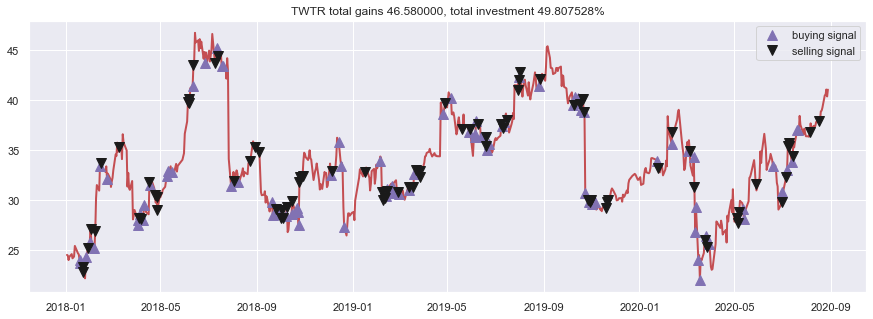

In [47]:
fig = plt.figure(figsize = (15, 5))
plt.plot(df['Close'], color='r', lw=2.)
plt.plot(df['Close'], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(df['Close'], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('TWTR total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [ ]:
from datetime import datetime

volume = df['Volume'].tolist()

for i in range(100):
    print(agent.trade([real_trend[i], volume[i]]))

import copy
import pickle

copy_model = copy.deepcopy(agent.model)

with open('model.pkl', 'wb') as fopen:
    pickle.dump(copy_model, fopen)

